# 7. Dense network

First, we reimport libraries, arrays and list we are going to use for this section (from previous notebook)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from IPython.display import display

In [3]:
class_labels = [0, 1, 2, 3, 4, 5]
class_names = ['bike', 'car', 'motorcycle', 'other', 'truck', 'van'] 
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

with np.load('train_features.npz') as train_data:
    train_features = train_data['features']
    train_labels = train_data['labels']
    train_images = train_data['images']

X_train = np.array(train_features)
y_train = np.array(train_labels)
images_train = np.array(train_images)


with np.load('valid_features.npz') as valid_data:
    valid_features = valid_data['features']
    valid_labels = valid_data['labels']
    valid_images = valid_data['images']

X_valid = np.array(valid_features)
y_valid = np.array(valid_labels)
images_valid = np.array(valid_images)

with np.load('test_features.npz') as test_data:
    test_features = test_data['features']
    test_labels = test_data['labels']
    test_images = test_data['images']

X_test = np.array(test_features)
y_test = np.array(test_labels)
images_test = np.array(test_images)

In [4]:
X_train.shape

(280, 1280)

In [5]:
# Concatenate X_train and X_valid along the first axis
X_train = np.concatenate((X_train, X_valid), axis=0)
y_train = np.concatenate((y_train, y_valid), axis=0)
images_train = np.concatenate((images_train, images_valid), axis=0)

In [6]:
X_train.shape

(419, 1280)

## 1-layer dense network

We use Keras API to implement, as told in course
> this approach is quicker to implement, more straightforward to read and most importantly, the Keras API is since TensorFlow version 2.0 also the preferred API of TensorFlow itself.

Sequential is the Keras model API that allows us to stack layers in a linear manner. The Dense layer is the simplest and most common type of layer, where every input node is connected to every output node with a weight.

In our case, we only have one output node since we are doing binary classification, and we use the `softmax` activation function to convert output value between 0 and 1

We use as loss function `sparse_categorical_crossentropy` as this is the case of multi-class classification where the output  is a probability distribution over multiple classes. `categorical_crossentropy` in the case where target is one hot encoded, and `sparse_categorical_crossentropy` in the case where target are integers representing true classes.

We use GridSearchCV to find best set of  hyperparameters. We chose to
* Apply dropout and regularizers for weight coefficients passed from input layer (1280 features) to output layer (6 labels). 
* Test different batchsizes, relatively low as training dataset is relatively small, and we want to avoid overfitting

Function create_model is defined to create the neural network with a given set of hyperparameters. KerasClassifier from scikeras.wrappers puts the neural network model into an estimator object used within GridSearchCV. We add through callbacks in GridSearchCV EarlyStopping to stop learning if loss on validation set is not improving after 10 epochs.

It is important to note that in the param_grid dictionnary, some parameters are use in the function create_model and others directly in the fitting step of GridSearchCV. Parameters that are pass within function need to be defined in estimator objects KerasClassifier, example `model__reg_strength=None`, or they are not registered/tunable. Parameters used in fitting, as `fit__batch_size` don't need to be defined in KerasClassifier.

In [7]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasClassifier
from keras import activations, initializers, callbacks
from tensorflow.keras.callbacks import EarlyStopping

# Function to create model, required for KerasClassifier
def create_model(reg_strength):
    model = Sequential()
    model.add(Dense(6, input_shape=(1280,),
                    activation=activations.softmax,
                    kernel_regularizer=regularizers.l2(reg_strength)
                   ))
    model.add(Dropout(0.1))
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(
    model=create_model,
    reg_strength=None,
    verbose=0
)

# Define the grid of hyperparameters to search
# test batch sizes
param_grid = {
    'fit__batch_size': [16, 32],
    'model__reg_strength': [0.001, 0.01, 0.1]
}

early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1
)

# Fit the model with early stopping
grid_result = grid.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stop])

# Print the best hyperparameters and accuracy
print(f'Best score: {grid_result.best_score_}, Best params: {grid_result.best_params_}')

# Evaluation on test data
best_model = grid.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Accuracy on unseen test data:: {:.2f}%".format(test_score * 100))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score: 0.9021801491681011, Best params: {'fit__batch_size': 32, 'model__reg_strength': 0.001}
Accuracy on unseen test data:: 98.00%


Looked at [documentation](https://www.adriangb.com/scikeras/stable/advanced.html) with implement Kera and this [article](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/) was useful in getting ideas for parameters. Also referencing the following pages as some trial and error was required to understand proper syntax in using KerasClassifier and create_model, especially the part for which parameter needed to be within KerasClassifier. (
[Source 1](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)
[Source 2](http://ethen8181.github.io/machine-learning/keras/nn_keras_hyperparameter_tuning.html)
[Source 3](https://datagraphi.com/blog/post/2019/12/17/how-to-find-the-optimum-number-of-hidden-layers-and-nodes-in-a-neural-network-model)
[Source 4](https://coderzcolumn.com/tutorials/artificial-intelligence/scikeras-give-scikit-learn-like-api-to-your-keras-networks)
).

In [8]:
best_params = grid_result.best_params_
model = create_model(best_params['model__reg_strength'])

history = model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=100,
    batch_size=best_params['fit__batch_size'],
    callbacks=[early_stop],
    verbose=0
)

Epoch 00019: early stopping


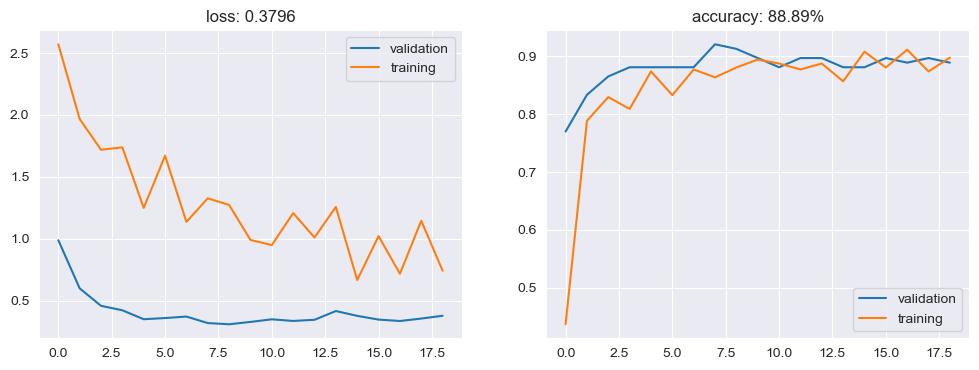

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title("loss: {:.4f}".format(history.history["val_loss"][-1]))
ax1.plot(history.history["val_loss"], label="validation")
ax1.plot(history.history["loss"], label="training")
ax1.legend()

# plot accuracy values
ax2.set_title("accuracy: {:.2f}%".format(history.history["val_accuracy"][-1] * 100))
ax2.plot(history.history["val_accuracy"], label="validation")
ax2.plot(history.history["accuracy"], label="training")
ax2.legend()

plt.show()

Model does not blatantly over or under fit. And accuracy on testing data is the best we have achieved accross all models.

## 2-layer dense network
i.e. one hidden layer

Based on comment from M. Dia [here](https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v3/subjects/multilayer-and-convolutional-neural-networks-v4/units/multilayer-networks-v4)
> You should always use activation functions for hidden layers in the neural network, otherwise your network will be the same as a simple linear model (linear regression or logistic regression). Whether to choose Sigmoid, ReLU, Tanh (tangent hyperbolic), or any other function for the activation of the hidden layers depends on the data and specific setup. The type of the activation function is one of the hyperparameters that you can tune. A common choice based on previous experimentation is the ReLU function. It was proven that ReLU is numerically more stable than Sigmoid with very deep neural networks. This is because ReLU suffers less from the Vanishing Gradient Problem, as it is saturated from the left-side only. You can stick with ReLU for the hidden layers. However, note that the activation function at the output layer depends on the task and you don't have much freedom there. If the task is a binary classification, then the output activation is Sigmoid. If it is a _multi-class classification, the output activation is Softmax_.

We use ReLU for hidden Layer and Softmax for output activation

In [10]:
def create_model(reg_strength, dropout, learning_rate, num_neurons):
    model = Sequential()
    model.add(Dense(num_neurons, input_shape=(1280,),
                    activation=activations.relu,
                    kernel_regularizer=regularizers.l2(reg_strength)
                   ))
    model.add(Dropout(dropout))
    model.add(Dense(6,
                    activation=activations.softmax,
                    kernel_regularizer=regularizers.l2(reg_strength)
                   ))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                 )
    return model

model = KerasClassifier(
    model=create_model,
    reg_strength=None,
    dropout=None,
    learning_rate=None,
    num_neurons=None,
    verbose=0
)

# Define the grid of hyperparameters to search
# test batch sizes
param_grid = {
    'fit__batch_size': [32, 64],
    'model__reg_strength': [0.001, 0.01],
    'model__dropout': [0.1, 0.2],
    'model__learning_rate': [0.001, 0.01],
    'model__num_neurons': [32, 64, 128]
}

early_stop = EarlyStopping(monitor='val_accuracy', verbose=1, patience=10)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1
)

# Fit the model with early stopping
grid_result = grid.fit(X_train, y_train, validation_split=0.3, epochs=100, callbacks=[early_stop])

# Print the best hyperparameters and accuracy
print(f'Best score: {grid_result.best_score_}, Best params: {grid_result.best_params_}')

# Evaluation on test data
best_model = grid.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Accuracy on unseen test data:: {:.2f}%".format(test_score * 100))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.9092943201376936, Best params: {'fit__batch_size': 64, 'model__dropout': 0.1, 'model__learning_rate': 0.001, 'model__num_neurons': 128, 'model__reg_strength': 0.001}
Accuracy on unseen test data:: 96.00%


In [11]:
best_params = grid_result.best_params_
model = create_model(
    best_params['model__reg_strength'],
    best_params['model__dropout'],
    best_params['model__learning_rate'],
    best_params['model__num_neurons'],
)

history = model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=100,
    batch_size=best_params['fit__batch_size'],
    callbacks=[early_stop],
    verbose=0
)

Epoch 00015: early stopping


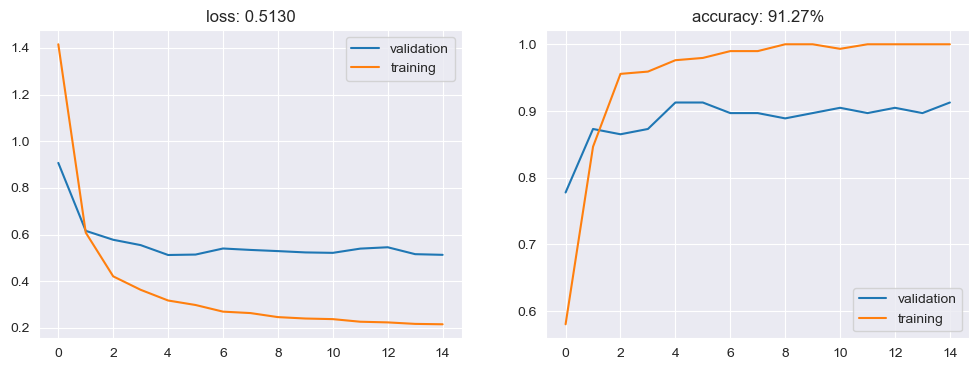

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title("loss: {:.4f}".format(history.history["val_loss"][-1]))
ax1.plot(history.history["val_loss"], label="validation")
ax1.plot(history.history["loss"], label="training")
ax1.legend()

# plot accuracy values
ax2.set_title("accuracy: {:.2f}%".format(history.history["val_accuracy"][-1] * 100))
ax2.plot(history.history["val_accuracy"], label="validation")
ax2.plot(history.history["accuracy"], label="training")
ax2.legend()

plt.show()

Better accuracy but higher loss on validation set with one hidden layer. We see bigger overfitting with one hidden layer than no hidden layer, which leads us to believe that as we have little data to train/validate/test on, we are not really benefiting from increasing model complexity.
Accuracy on unseen test data is lower, but is possible that we bigger testing set, we would see an improvement.